# Evolving vector-space model

This lab will be devoted to the use of `doc2vec` model for the needs of information retrieval and text classification.  

## 1. Searching in the curious facts database
The facts dataset is given [here](https://github.com/hsu-ai-course/hsu.ai/blob/master/code/datasets/nlp/facts.txt), take a look.  We want you to retrieve facts relevant to the query, for example, you type "good mood", and get to know that Cherophobia is the fear of fun. For this, the idea is to utilize document vectors. However, instead of forming vectors with tf-idf and reducing dimensions, this time we want to obtain fixed-size vectors for documents using `doc2vec` model.

### 1.1 Loading trained `doc2vec` model

First, let's load the pre-trained `doc2vec` model from https://github.com/jhlau/doc2vec (Associated Press News DBOW (0.6GB))

In [1]:
!pip install gensim

  Stored in directory: C:\Users\Rufina\AppData\Local\pip\Cache\wheels\ab\10\93\5cff86f5b721d77edaecc29959b1c60d894be1f66d91407d28
Successfully built smart-open


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [4]:
from gensim.models.doc2vec import Doc2Vec

# unpack a model into 3 files and target the main one
# doc2vec.bin  <---------- this
# doc2vec.bin.syn0.npy
# doc2vec.bin.sin1neg.npy
model = Doc2Vec.load('doc2vec.bin', mmap=None)
print(type(model))
print(type(model.infer_vector(["to", "be", "or", "not"])))

<class 'gensim.models.doc2vec.Doc2Vec'>
<class 'numpy.ndarray'>


### 1.2 Reading data

Now, let's read the facts dataset. Download it from the abovementioned url and read to the list of sentences.

In [56]:
#TODO read facts into list
from bs4 import BeautifulSoup
from bs4.element import Comment
import urllib.parse
import requests
from urllib.parse import quote
from nltk.tokenize import sent_tokenize
from gensim.summarization.textcleaner import get_sentences
import re

class Document:
    
    def __init__(self, url):
        self.url = url
        
    def get(self):
        if not self.load():
            if not self.download():
                raise FileNotFoundError(self.url)
            else:
                self.persist()
    
    def download(self):
        try:
            response = requests.get(self.url)
            if response.status_code == 200:
                self.content = response.content
                return True
            else:
                return False
        except:
            return False
    
    def persist(self):
        with open(quote(self.url).replace('/', '_'), 'wb') as f:
            f.write(self.content)
            
    def load(self):
        # print("Loading from drive")
        try:
            with open(quote(self.url).replace('/', '_'), 'rb') as f:
                self.content = f.read()
            # print("Loaded from drive")
            return True
        except:
            return False


        
facts_url = 'https://raw.githubusercontent.com/hsu-ai-course/hsu.ai/master/code/datasets/nlp/facts.txt'
doc = HtmlDocument(facts_url)
doc.get()
file1 = open(quote(facts_url).replace('/', '_'), 'r') 
Lines = file1.readlines() 
facts = [l for l in Lines]

### 1.3 Tests

In [57]:
print(*facts[:5], sep='\n')

assert len(facts) == 159
assert ('our lovely little planet') in facts[0]

1. If you somehow found a way to extract all of the gold from the bubbling core of our lovely little planet, you would be able to cover all of the land in a layer of gold up to your knees.

2. McDonalds calls frequent buyers of their food “heavy users.”

3. The average person spends 6 months of their lifetime waiting on a red light to turn green.

4. The largest recorded snowflake was in Keogh, MT during year 1887, and was 15 inches wide.

5. You burn more calories sleeping than you do watching television.



### 1.4  Transforming sentences to vectors

Transform the list of facts to numpy array of vectors corresponding to each document (`sent_vecs`), inferring them from the model we just loaded.

In [105]:
#TODO infer vectors
import numpy as np


#inference hyper-parameters
start_alpha=0.01
infer_epoch=1000
sent_vecs = np.array([model.infer_vector(f.lower().split(), alpha=start_alpha, steps=infer_epoch) for f in facts])

### 1.5 Tests 

In [93]:
print(sent_vecs.shape)
assert sent_vecs.shape == (159, 300)

(159, 300)


### 1.6 Find closest

Now, reusing the code from the last lab, find facts which are closest to the query using cosine similarity measure.

In [106]:
#TODO output closest facts to the query
def norm_vectors(A):
    An = A.copy()
    for i, row in enumerate(An):
        An[i, :] /= np.linalg.norm(row) + 0.0001
    return An

def find_k_closest(query, dataset, k=5): 
    dataset = norm_vectors(dataset)
    query = norm_vectors(query.reshape(1,-1))
    index = list((i, v, np.dot(query[0], v)) for i, v in enumerate(dataset))    
    return sorted(index, key=lambda pair: pair[2], reverse=True)[:k]

query = "good mood"
query_vec = model.infer_vector(query.lower().split(), alpha=start_alpha, steps=infer_epoch)
r = find_k_closest(query_vec, sent_vecs)

print("Results for query:", query)
for k, v, p in r:
    print("\t", facts[k], "sim=", p)

Results for query: good mood
	 121. Birds don’t urinate.
 sim= 0.52012867
	 150. You can’t hum while holding your nose closed.
 sim= 0.498863
	 144. Dolphins sleep with one eye open!
 sim= 0.4937086
	 155. On Jupiter and Saturn it rains diamonds. sim= 0.4793191
	 97. 111,111,111 X 111,111,111 = 12,345,678,987,654,321
 sim= 0.47703522


## 2. Training doc2vec model and documents classifier

Now we would like you to train doc2vec model yourself based on [this topic-modeling dataset](https://code.google.com/archive/p/topic-modeling-tool/downloads).

### 2.1 Read dataset

First, read the dataset - it consists of 4 parts, you need to merge them into single list. 

In [148]:
#TODO read the dataset into list
file_names = ['testdata_braininjury_10000docs.txt','testdata_news_economy_2073docs.txt',
             'testdata_news_fuel_845docs.txt', 'testdata_news_music_2084docs.txt']
index_to_tag = {0:'braininjury', 1:'economy', 2:'fuel', 3:'music'}
file_labels = [0, 1, 2, 3]
all_data, all_labels = [], []
for path, label in zip(file_names, file_labels):
    file = open(path, 'r') 
    for line in file.readlines():
        all_data.append(line.lower().split())
        all_labels.append(label)
all_labels = np.array(all_labels)

### 2.2 Tests 

In [149]:
print(len(all_data))
assert len(all_data) == 15002

15002


### 2.3 Training `doc2vec` model

Train a `doc2vec` model based on the dataset you've loaded. The example of training is provided.

In [186]:
#TODO change this according to the task
# small set of tokenized sentences
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
# just a test set of tokenized sentences
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(all_data)]
# train a model
model = Doc2Vec(
    documents,     # collection of texts
    vector_size=5, # output vector size
    window=2,      # maximum distance between the target word and its neighboring word
    min_count=1,   # minimal number of 
    workers=4      # in parallel
)

# clean training data
model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

# save and load
model.save("d2v.model")
model = Doc2Vec.load("d2v.model")

vec = model.infer_vector(["system", "response"])
print(vec)

[-0.06089206  0.02674813  0.0978206   0.09179214 -0.07358344]


### 2.4 Form train and test datasets

Transform documents to vectors and split data to train and test sets. Make sure that the split is stratified as the classes are imbalanced.

In [187]:
#TODO transform and make a train-test split
from sklearn.model_selection import StratifiedShuffleSplit
all_data_transformed = []

for line in all_data:
    all_data_transformed.append(model.infer_vector(line))
all_data_transformed = np.array(all_data_transformed)

In [188]:
from collections import Counter
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
for train_index, test_index in sss.split(all_data_transformed, all_labels):
    X_train, X_test = all_data_transformed[train_index], all_data_transformed[test_index]
    y_train, y_test = all_labels[train_index.astype(int)], all_labels[test_index.astype(int)]
print(f'train set {Counter(y_train)}')
print(f'test set {Counter(y_test)}')

# X_train, X_test, y_train, y_test = sss.get_n_splits(all_data, all_labels)

train set Counter({0: 7000, 3: 1459, 1: 1451, 2: 591})
test set Counter({0: 3000, 3: 625, 1: 622, 2: 254})


### 2.5 Train topics classifier

Train a classifier that would classify any document to one of four categories: fuel, brain injury, music, and economy.
Print a classification report for test data.

In [192]:
#TODO train a classifier and measure its performance
from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeClassifier 
dtree_model = DecisionTreeClassifier(max_depth = 5).fit(X_train, y_train)
dtree_predictions = dtree_model.predict(X_test) 

from sklearn.metrics import classification_report
print(classification_report(y_test, dtree_predictions))
print(index_to_tag)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3000
           1       0.64      0.76      0.69       622
           2       0.65      0.07      0.12       254
           3       0.70      0.84      0.76       625

   micro avg       0.89      0.89      0.89      4501
   macro avg       0.75      0.66      0.64      4501
weighted avg       0.89      0.89      0.87      4501

{0: 'braininjury', 1: 'economy', 2: 'fuel', 3: 'music'}


Which class is the hardest one to recognize?

The hardest class to recognize is fuel

### 2.6 Bonus task

What if we trained our `doc2vec` model using window size = 5 or 10? Would it improve the classification acccuracy? What about vector dimensionality? Does it mean that increasing it we will achieve better performance in terms of classification?

Explore the influence of these parameters on classification performance, visualizing it as a graph (e.g. window size vs f1-score, vector dim vs f1-score).

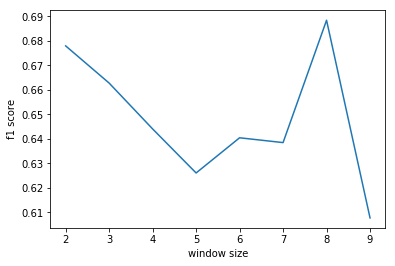

In [194]:
#TODO bonus task
from sklearn.metrics import f1_score
window_sizes = [i for i in range(2,10)]
f1_scores = []
for ws in window_sizes:
    model = Doc2Vec(
        documents,     # collection of texts
        vector_size=5, # output vector size
        window=ws,      # maximum distance between the target word and its neighboring word
        min_count=1,   # minimal number of 
        workers=4      # in parallel
    )

    # clean training data
    model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    all_data_transformed = []
    for line in all_data:
        all_data_transformed.append(model.infer_vector(line))y
    all_data_transformed = np.array(all_data_transformed)
    
    X_train, X_test = all_data_transformed[train_index], all_data_transformed[test_index]
    y_train, y_test = all_labels[train_index], all_labels[test_index]
    
    dtree_model = DecisionTreeClassifier(max_depth = 5).fit(X_train, y_train) 
    dtree_predictions = dtree_model.predict(X_test) 
    f1_scores.append(f1_score(y_test, dtree_predictions, average='macro'))
    
plt.plot(window_sizes, f1_scores)
plt.xlabel('window size')
plt.ylabel('f1 score')
plt.show()

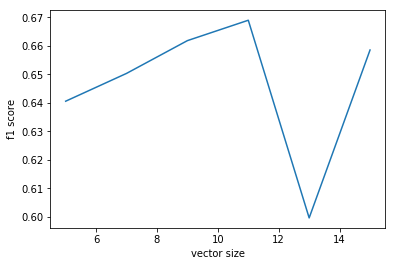

In [196]:
#TODO bonus task
from sklearn.metrics import f1_score
vector_sizes = [5,7,9,11,13,15]
f1_scores = []
for vs in vector_sizes:
    model = Doc2Vec(
        documents,     # collection of texts
        vector_size=vs, # output vector size
        window=5,      # maximum distance between the target word and its neighboring word
        min_count=1,   # minimal number of 
        workers=4      # in parallel
    )

    # clean training data
    model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    all_data_transformed = []
    for line in all_data:
        all_data_transformed.append(model.infer_vector(line))
    all_data_transformed = np.array(all_data_transformed)
    
    for train_index, test_index in sss.split(all_data_transformed, all_labels):
        X_train, X_test = all_data_transformed[train_index], all_data_transformed[test_index]
        y_train, y_test = all_labels[train_index.astype(int)], all_labels[test_index.astype(int)]
        
    dtree_model = DecisionTreeClassifier(max_depth = 5).fit(X_train, y_train) 
    dtree_predictions = dtree_model.predict(X_test) 
    f1_scores.append(f1_score(y_test, dtree_predictions, average='macro'))
    
plt.plot(vector_sizes, f1_scores)
plt.xlabel('vector size')
plt.ylabel('f1 score')
plt.show()